# This notebook tries to have same amount of values in the beacons - fill in numpy arrays with -1 to then make easier numpy array operations

1. input old functions 
2. create an array withffilled extra numbers if max larger = new max 
3. calculate statistics, just ignore the -1 


In [ ]:
Get things in order - have all functions at first then slowly go for the overall graphs - to smaller ones 

####    Creating arrays to compute statistics on... 

In [221]:
import math
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
#import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from numpy import median
from scipy.stats import ranksums
from Data_analysis import *
import numpy as np
import scipy.stats as stats

from tqdm import tqdm_notebook as tqdm


root = 'C:/Users/Fabian/Desktop/Analysis/Multiple_trial_analysis/Data/Raw/'
processed = 'C:/Users/Fabian/Desktop/Analysis/Multiple_trial_analysis/Data/Processed/'

figures = 'C:/Users/Fabian/Desktop/Analysis/Multiple_trial_analysis/Figures/'

vor = 'C:/Users/Fabian/Desktop/Analysis/Multiple_trial_analysis/Data/Raw/'
pc = 'C:/Users/Fabian/Desktop/Multiple_trial_analysis-20200712T151410Z-001/Multiple_trial_analysis/Data/Raw/'

In [2]:
Day86_fs2 = pd.read_csv(root+'position 20200128-160013.txt',sep=" ", header=None)
Day86_fs1 = pd.read_csv(root+'position 20200128-151826.txt',sep=" ", header=None)

beacon_Day86_fs2 = pd.read_csv(root+'beacons 20200128-160013.txt',sep=" ", header=None)
beacon_Day86_fs1 = pd.read_csv(root+'beacons 20200128-151826.txt',sep=" ", header=None)

beacon_data = beacon_Day86_fs1
position_data = Day86_fs1

beacons = [beacon_Day86_fs1,beacon_Day87_fs1,beacon_Day88_fs1,beacon_Day89_fs1,beacon_Day90_fs1,beacon_Day91_fs1,beacon_Day92_fs1,beacon_Day93_fs1]
beacons2 = [beacon_Day86_fs2,beacon_Day87_fs2,beacon_Day88_fs2,beacon_Day89_fs2,beacon_Day90_fs2,beacon_Day91_fs2,beacon_Day92_fs2,beacon_Day93_fs2]
list_of_days = [Day86_fs1,Day87_fs1,Day88_fs1,Day89_fs1,Day90_fs1,Day91_fs1,Day92_fs1,Day93_fs1]
list_of_days2 = [Day86_fs2,Day87_fs2,Day88_fs2,Day89_fs2,Day90_fs2,Day91_fs2,Day92_fs2,Day93_fs2]
Day_list = list_of_days+list_of_days2
Beacon_list = beacons+beacons2
len(Day_list)== len(Beacon_list) 

True

## 1. input old functions 
 

In [3]:
def get_positions_before_sham(seconds_back, idxs, position_data):
    """create arrays of positions before beacon reached"""
    beacon_periods = []
    randoms = rn.sample(range(1, len(position_data)), len(idxs))
    randoms.sort()
    for beacon_idx in randoms:
        beacon_t = position_data[beacon_idx][0]
        beacon_t_before = beacon_t - seconds_back
        before_idx = np.abs(beacon_t_before - position_data[:, 0]).argmin()
        beacon_periods.append(position_data[before_idx:beacon_idx])
        
    return beacon_periods

def get_index_at_pos(beacon_data, position_data):
    indexes = []
    for beacon_t in beacon_data[:, 0]:
        indexes.append( np.abs(beacon_t - position_data[:, 0]).argmin() )
        
    return indexes


def get_positions_before(seconds_back, idxs, position_data):
    """create arrays of positions before beacon reached"""
    beacon_periods = []
    for beacon_idx in idxs:
        beacon_t = position_data[beacon_idx][0]
        beacon_t_before = beacon_t - seconds_back
        before_idx = np.abs(beacon_t_before - position_data[:, 0]).argmin()
        beacon_periods.append(position_data[before_idx:beacon_idx])
        
    return beacon_periods
def ratios (list1,list2):
    resultant= (np.asarray(list1),np.asarray(list2))
    div = []
    for i in range(len(resultant[1])):
        if resultant[1][i]==0: #in case rat does not move in .1 sec - lost of tracking etc... 
            div.append(1)
        else:
            div.append(resultant[1][i]/resultant[0][i])
    return np.asarray(div)

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h



### 2. create an array with filled extra numbers if max larger = new max 


In [4]:
inti = np.empty([16,198,36])
inti.shape

(16, 198, 36)

#### a. check max lenght of beacon - 

In [5]:
max_beacon = []
for index,(position,beaconz) in enumerate(zip (Day_list,Beacon_list)): 
    beacon_d = beaconz.to_numpy()
    pos_data = position.to_numpy()
    max_beacon.append(len(beacon_d))
    beacon_d[:, 0] -= pos_data[0][0]
    pos_data[:, 0] -= pos_data[0][0]
    idxs = get_index_at_pos(beacon_d, pos_data)
    beacon_travel = get_positions_before(3, idxs ,pos_data) 
    for beacon in range(len(beacon_travel)):
        maxy= beacon_travel[beacon].max()
maximum_beacons_in_session = max(max_beacon)


In [94]:
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t,), mode='constant',constant_values = (np.nan))
#np.pad(np.ones(2,dtype=float),1,mode='constant',constant_values=(np.nan,))

padarray([1.,2.,3.], 10)

array([ 1.,  2.,  3., nan, nan, nan, nan, nan, nan, nan])

## b. Create part array filled with -1  - can also be filled with median, means or whatever numbers. ( len = 200,16,Mx beacon = 39)

In [7]:
mega=[]
for i in tqdm(range(2,10,1)): 
    session_all= []
    for index,(position,beaconz) in enumerate(zip (Day_list,Beacon_list)):
        beacon_d = beaconz.to_numpy()
        pos_data = position.to_numpy()
        beacon_d[:, 0] -= pos_data[0][0]
        pos_data[:, 0] -= pos_data[0][0]
        idxs = get_index_at_pos(beacon_d, pos_data)
        div = []
        beacon_travel = get_positions_before(i/10, idxs ,pos_data)    
        straights=[]
        longs=[]
        for beacon in range(len(beacon_travel)):
            longs.append(calculate_Distance(beacon_travel[beacon][:,1],beacon_travel[beacon][:,3]))
            straights.append(math.sqrt((beacon_travel[beacon][0,1] - beacon_travel[beacon][-1,1]) ** 2 + (beacon_travel[beacon][0,3] - beacon_travel[beacon][-1,3]) ** 2))
        div= (np.asarray((ratios(longs,straights))))
        large_div = padarray(div,maximum_beacons_in_session)
        session_all.append(large_div)
    mega.append(np.asarray(session_all))
mega

[array([[0.98205855, 0.86488493, 0.93501501, 0.92237815, 0.93285944,
         0.94994567, 0.4933277 , 0.90720054, 0.50894566, 0.98277696,
         0.44747326, 0.30123888, 0.73662023, 0.85343772, 0.84558434,
         0.96604354, 0.8847841 , 0.20283676, 0.86589623, 0.78731688,
         0.54432408, 0.95207606, 0.68788651, 0.68149707, 0.4341414 ,
         0.96146786, 0.9483442 , 0.9786798 , 0.68145043, 0.98824498,
         0.94590034, 0.95086743, 0.8299481 , 0.81453503, 0.97374623,
                nan,        nan,        nan,        nan],
        [0.8579928 , 0.56532902, 0.97243563, 0.91275385, 0.74208742,
         0.09501643, 0.64734995, 0.72028322, 0.91859288, 0.90831102,
         0.97102095, 0.90046615, 0.81106827, 0.80409297, 0.42226244,
         0.64804065, 0.90910589,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan, 

In [8]:
np.asarray(mega).shape

(198, 16, 39)

In [9]:
print(mega[0][0])


[0.98205855 0.86488493 0.93501501 0.92237815 0.93285944 0.94994567
 0.4933277  0.90720054 0.50894566 0.98277696 0.44747326 0.30123888
 0.73662023 0.85343772 0.84558434 0.96604354 0.8847841  0.20283676
 0.86589623 0.78731688 0.54432408 0.95207606 0.68788651 0.68149707
 0.4341414  0.96146786 0.9483442  0.9786798  0.68145043 0.98824498
 0.94590034 0.95086743 0.8299481  0.81453503 0.97374623        nan
        nan        nan        nan]


### Make an array (16,20,39)

In [113]:
mega=[]
for index,(position,beaconz) in enumerate(zip (Day_list,Beacon_list)):  
    beacon_d = beaconz.to_numpy()
    pos_data = position.to_numpy()
    beacon_d[:, 0] -= pos_data[0][0]
    pos_data[:, 0] -= pos_data[0][0]
    idxs = get_index_at_pos(beacon_d, pos_data)
    session_all= []
    for i in tqdm(range(1,200,1)):
        div = []
        beacon_travel = get_positions_before(i/10, idxs ,pos_data)    
        straights=[]
        longs=[]
        for beacon in tqdm(range(len(beacon_travel))):
            longs.append(calculate_Distance(beacon_travel[beacon][:,1],beacon_travel[beacon][:,3]))
            straights.append(math.sqrt((beacon_travel[beacon][0,1] - beacon_travel[beacon][-1,1]) ** 2 + (beacon_travel[beacon][0,3] - beacon_travel[beacon][-1,3]) ** 2))
        div.append(np.asarray((ratios(longs,straights))))
        large_div = padarray(div[0],maximum_beacons_in_session)
        session_all.append(large_div)
    mega.append(np.asarray(session_all))
mega[0]

array([[0.98878513, 1.        , 0.89545278, ...,        nan,        nan,
               nan],
       [0.98205855, 0.86488493, 0.93501501, ...,        nan,        nan,
               nan],
       [0.96921288, 0.9024964 , 0.62244475, ...,        nan,        nan,
               nan],
       ...,
       [0.4322031 , 0.23023703, 0.15846712, ...,        nan,        nan,
               nan],
       [0.4322031 , 0.22330399, 0.15359165, ...,        nan,        nan,
               nan],
       [0.4322031 , 0.2154006 , 0.14609786, ...,        nan,        nan,
               nan]])

In [115]:
np.array(mega).shape

(16, 199, 39)

In [114]:
print(mega[0][0])

[0.98878513 1.         0.89545278 0.99340809 0.93195589 0.97399601
 0.86584882 0.86367572 0.96652971 0.98542112 0.32058921 0.57956368
 0.9341774  0.91661011 0.99326489 0.98074603 0.99235476 0.44043021
 0.99142514 0.86370044 0.76526923 0.98467026 0.53820969 0.63933597
 0.9139071  0.93156772 0.88563446 0.95611452 0.84130014 0.99714787
 0.99658311 0.98926293 0.80283391 0.8438068  0.9828148         nan
        nan        nan        nan]


# Sham_Calculations 


In [137]:
import random as rn

In [ ]:


boot_reps=1000
ave_grand=[]
for i in tqdm(range (boot_reps)):
    mega_sham=[]
    for index,(position,beaconz) in enumerate(zip (Day_list,Beacon_list)):  
        beacon_d = beaconz.to_numpy()
        pos_data = position.to_numpy()
        beacon_d[:, 0] -= pos_data[0][0]
        pos_data[:, 0] -= pos_data[0][0]
        idxs = get_index_at_pos(beacon_d, pos_data)
        session_all= []
        for i in tqdm(range(2,200,1)):
            div = []
            beacon_travel = get_positions_before_sham(i/10, idxs ,pos_data)    
            straights=[]
            longs=[]
            for beacon in range(len(beacon_travel)):
                longs.append(calculate_Distance(beacon_travel[beacon][:,1],beacon_travel[beacon][:,3]))
                straights.append(math.sqrt((beacon_travel[beacon][0,1] - beacon_travel[beacon][-1,1]) ** 2 + (beacon_travel[beacon][0,3] - beacon_travel[beacon][-1,3]) ** 2))
            div.append(np.asarray((ratios(longs,straights))))
            large_div = padarray(div[0],maximum_beacons_in_session)
            session_all.append(large_div)
        mega_sham.append(np.asarray(session_all))
    ave_grand.append(mega_sham)    
ave_all_boot= np.mean(np.asarray(ave_grand),axis = 0 )
np.array(ave_grand).shape

In [ ]:
mega_sham = np.array(ave_grand)

In [ ]:
np.save('%s1000_bootstrapped_20_secs_back_full'%processed, np.asarray(ave_grand))

#### Adding all beacons to a similiar list - i.e varying lenghts - then add the list to numpy of 16 and to numpy of 200 
Maybe should also process data - so that the timing is corrected... 

#### Now it is a Numpy array containing a list such as (Time- back from beacon, session, list of variable lenghts beacon ratios - still can do some numpy operations on it. 


## Now can either recompute for everything or plot further with NA for the individual values. 


In [146]:
CI,CILow,CIHigh = mean_confidence_interval(mega_sham,0.95)



In [148]:


scipy.stats.mstats.zscore

times=[]
for time in mega:
    sessions=[]
    for session in time:
        z_score=[]
        #z_score.append(session - stats.nanmean(session)) / stats.nanstd(session)
        z_score.append(scipy.stats.mstats.zscore(np.array(session),axis=0,))
        sessions.append(z_score)
    times.append(np.array(sessions))
z_scored=np.array(times)



array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        ...,

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]],


       [[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        ...,

        [[      

In [20]:
scipy.stats.mstats.zscore?

In [116]:
a = np.array([np.nan,  0.0767,  0.4383,  0.7866,  0.8091,  0.1954,  0.6307, 0.6599, 0.1065,  0.0508])
ZScore_a = stats.zscore(a,nan_policy='omit')

print(ZScore_a)

TypeError: zscore() got an unexpected keyword argument 'nan_policy'

## Need to get to 198,16,1 for plotting - so one number for each .1 second for eacch session 

In [117]:
All_sessions_all_beacons = np.asarray(mega)


In [157]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.nanmean(a), scipy.stats.sem(a,nan_policy='omit')
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [180]:
import numpy as np, scipy.stats as st
a=mega_sham[0][0][0]
print(a)
CI, CILO,CIHigh = mean_confidence_interval(mega_sham)
CI

[0.96320948 0.79490688 0.93233432 0.98816744 0.90279223 0.93547555
 0.97058332 0.95648923 0.81456621 0.71364294 0.89207928 0.34089663
 0.97227466 0.85621979 0.0080541  0.96487788 0.99963953 0.12518473
 0.99237814 0.81026881 0.97338466 0.93118783 0.72734961 0.91887771
 0.87406679 0.90373094 0.75780503 0.13215985 0.69619901 0.51855314
 0.79385107 0.26691105 0.99224502 0.277186   0.76688509        nan
        nan        nan        nan]


0.3474041193337786

In [206]:
z_scored = scipy.stats.zscore(All_sessions_all_beacons,)
Z_median = np.nanmedian(z_scored,axis=2)
medians = np.nanmedian(All_sessions_all_beacons,axis=2)
print(medians.shape)

(16, 199)


### For sham need to do it over 3rd axis - due to all the reps in the data

In [215]:
SEM = scipy.stats.sem(mega_sham,nan_policy='omit',axis=3)
Mean = np.nanmean(mega_sham,axis=3)
h = SEM * scipy.stats.t.ppf((1 + .95) / 2., 38)
SEM.shape
Mean.shape
h.shape
Confidence = Mean,Mean-h,Mean+h
Confidence = np.asarray(Confidence)

print(Confidence.shape)
CI =np.mean(Confidence[0],axis=0)
CILow=np.mean(Confidence[1],axis=0)
CIHigh=np.mean(Confidence[2],axis=0)

CI.shape

(3, 100, 16, 198)


(16, 198)

In [165]:
z_scored = scipy.stats.zscore(All_sessions_all_beacons,)
Z_median = np.nanmedian(z_scored,axis=2)
medians = np.nanmedian(All_sessions_all_beacons,axis=2)
Sessions=[]
for session in tqdm(mega_sham): 
    times=[]
    for time in session:
        beacons=[]
        for beacon in time:
            CI, CILow,CIHigh = mean_confidence_interval(beacon)
            beacons.append((CI, CILow,CIHigh))
        times.append(beacons)
    Sessions.append(times)
Confidence = np.asarray(sessions)




1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2


KeyboardInterrupt: 

In [168]:
Confidence.shape

(199, 1, 39)

### Should be 16,199,3

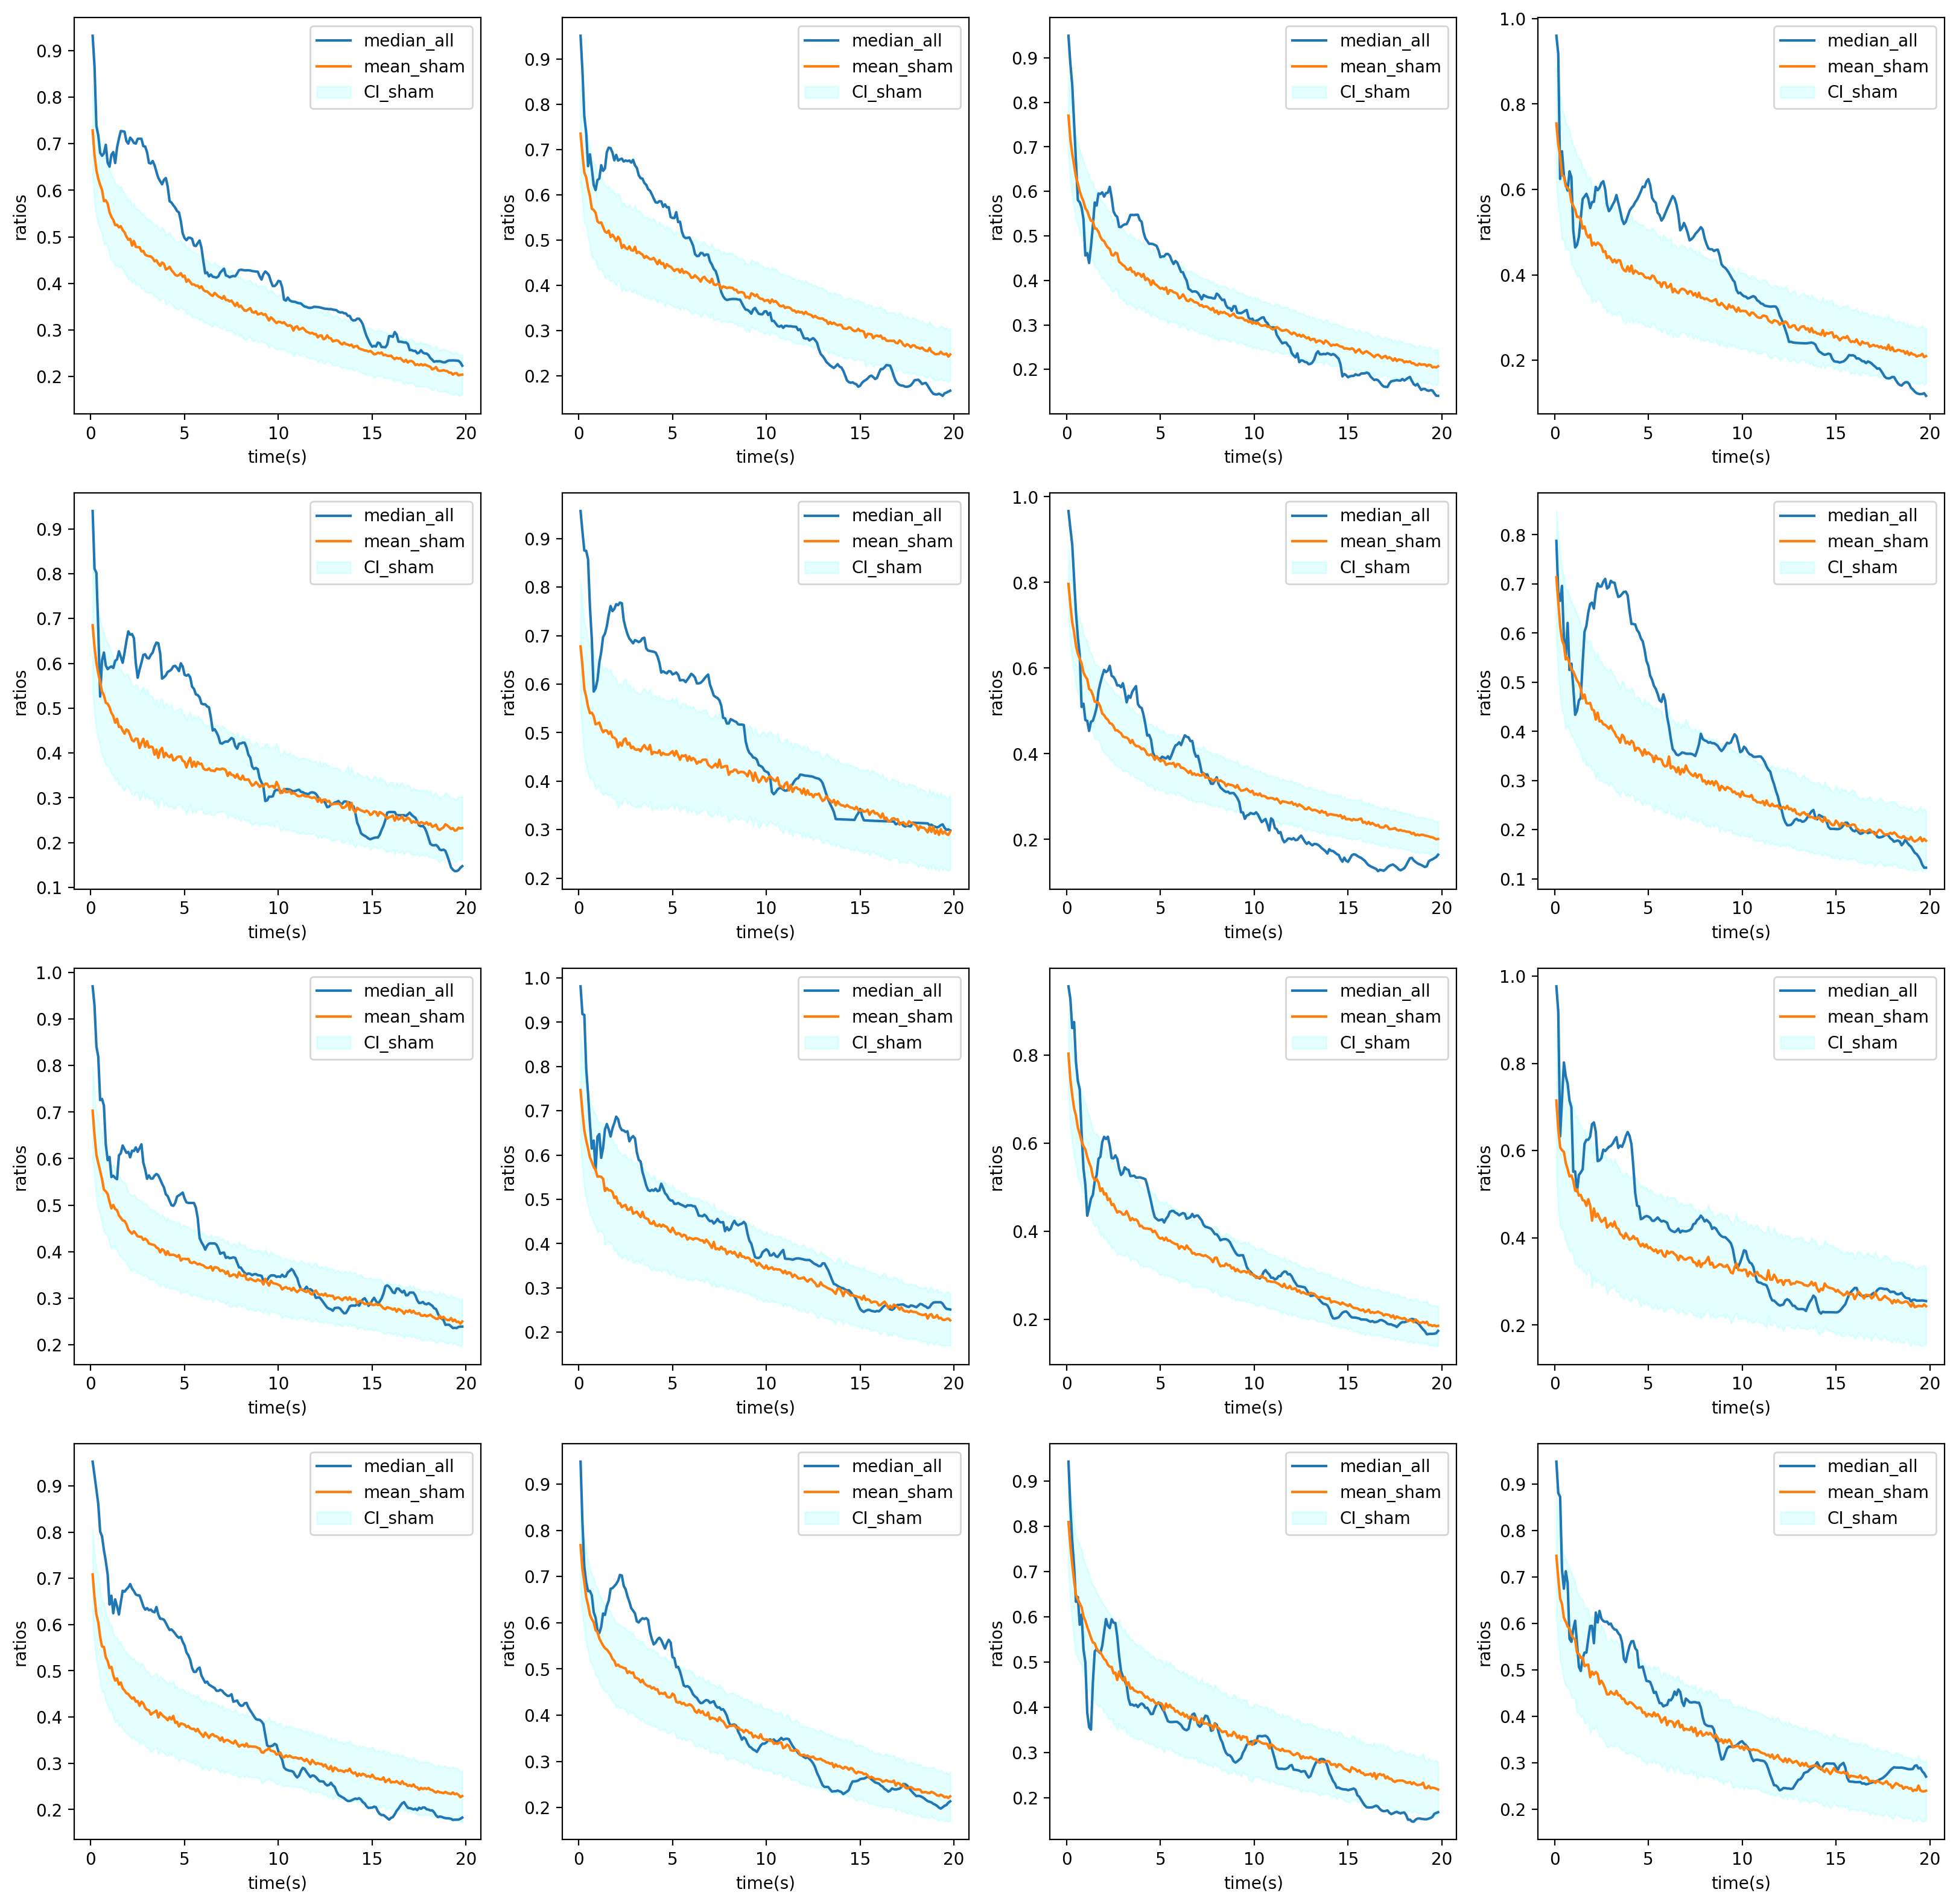

In [220]:

fig,ax = plt.subplots(4,4,figsize=(20,20),dpi=200)
num=0
h=0

#print(mega.shape)


secs_back=198
r1= np.arange(0.1,(secs_back/10)+.1,.1)
vis_invis_mean = "all"

#z_scored =np.asarray(mega).reshape(16,198,39) 
for index,(session_m,session,Mean,ConfLow,ConfHigh) in enumerate(zip (medians,Z_median,CI,CILow,CIHigh)):
    ax[h][num].plot(r1,session_m[:secs_back],label='median_%s'%vis_invis_mean)
    #ax[h][num].plot(r1,session[:secs_back],label='Z_score_median_%s'%vis_invis_mean)
    #ax[h][num].bar(r1,session,label='Z_score_sham_%s'%vis_invis_mean,alpha=.1)
    ax[h][num].plot(r1,Mean[:secs_back],label='mean_sham')
    #ax[h][num].plot(r1,boot[:secs_back,l1],label='mean_%s'%vis_invis_mean)
    #ax[h][num].plot(r1,boot[:secs_back,l2],label='median_%s'%vis_invis_mean)
    ax[h][num].fill_between(r1, ConfLow, ConfHigh, color='cyan', alpha=.1,label = 'CI_sham')

    ax[h][num].set_ylabel('ratios')
    ax[h][num].set_xlabel('time(s)')
    ax[h][num].legend()


    l=0
    s=0
    h+=1
    if h % 4==0:
        num += 1
        h=0
    #ax.set_ylabel('ratios')
plt.savefig('%s16_ratios__%s_sec._before_beacons_%s_.png' %(figures,secs_back/10,vis_invis_mean), dpi = 100)    
plt.show()